# Others
#### Author: JP Melo

### Imports

In [ ]:
from derpinns.nn import *
from derpinns.utils import *
from derpinns.trainer import *
import torch.nn as nn
import torch

## Parameters

In [ ]:
# Fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Global parameters
assets = 10

sampler = "pseudo"
nn_shape = "10x3"
device = torch.device("cpu")
dtype = torch.float32

# Define option valuation params
params = OptionParameters(
    n_assets=assets,
    tau=1.0,
    sigma=np.array([0.2] * assets),
    rho=np.eye(assets) + 0.25 * (np.ones((assets, assets)) - np.eye(assets)),
    r=0.05,
    strike=100,
    payoff=payoff
)

boundary_samples = 500
interior_samples = boundary_samples*assets*2
initial_samples = boundary_samples*assets*2

dataset = SampledDataset(
    params, interior_samples, initial_samples, boundary_samples, sampler, dtype, device, seed=0)
    
batch_size = len(dataset)  # we use all samples

## Training

In [ ]:
model = build_nn(
    nn_shape=nn_shape,
    input_dim=assets,
    dtype=torch.float32,
    activation=nn.Softplus(),
).apply(weights_init).to(device)

model.train()

optimizer = SSBroyden(
    model.parameters(),
    max_iter=1000,
)

closure = DimlessBSOnlyInterior()\
    .with_dataset(dataset, loader_opts={'batch_size': batch_size, "shuffle": True, "pin_memory": True})\
    .with_model(model)\
    .with_device(device)\
    .with_dtype(dtype)

trainer = PINNTrainer()\
    .with_optimizer(optimizer)\
    .with_device(device)\
    .with_dtype(dtype)\
    .with_training_step(closure)

trainer.train()

SSBroyden training: 100%|██████████| 1000/1000 [43:11<00:00,  2.59s/it, Interior=0.012575, Boundary=0.000000, Initial=0.032779, Total=0.045354, Max Error=13.716377, L2 Error=0.022402]


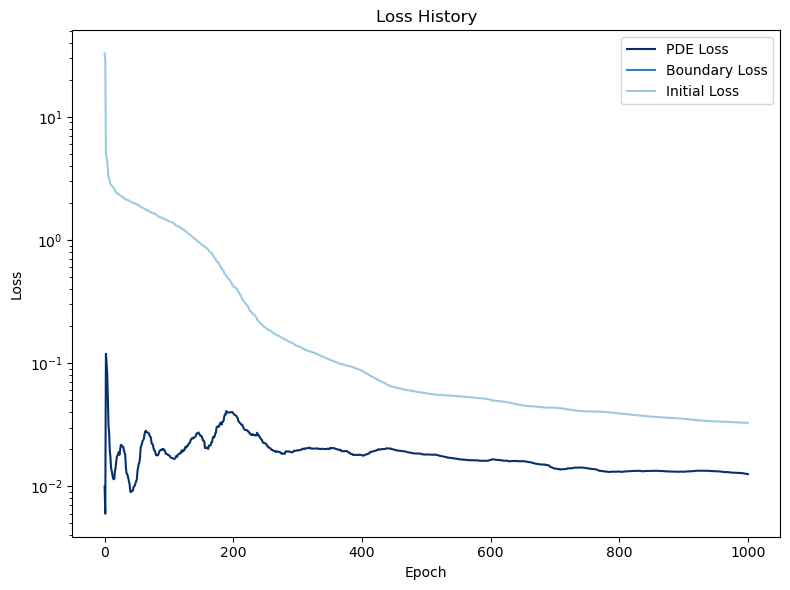

L2 Error:  3.9421823


In [ ]:
with_softplus = trainer.closure.get_state()
plot_loss(with_softplus, backend='matplotlib', smooth=False)

softplus_l2 = compare_with_mc(model, params, n_prices=200,
                          n_simulations=10_000, dtype=dtype, device=device, seed=42)['l2_rel_error']
print("L2 Error: ", softplus_l2*100)

In [ ]:
plot_solution_surface(model, params, assets, device, backend='plotly')

In [1]:
from derpinns.nn import *
from derpinns.utils import *
from derpinns.trainer import *
import torch.nn as nn
import torch
import kfac


/Users/josemelo/Desktop/master/tesis/codes/.conda/lib/python3.11/site-packages/kfac/base_preconditioner.py:15: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  from kfac.distributed import get_rank


In [2]:
# Fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Global parameters
assets = 5

sampler = "pseudo"
nn_shape = "10x3"
device = torch.device("cpu")
dtype = torch.float32

# Define option valuation params
params = OptionParameters(
    n_assets=assets,
    tau=1.0,
    sigma=np.array([0.2] * assets),
    rho=np.eye(assets) + 0.25 * (np.ones((assets, assets)) - np.eye(assets)),
    r=0.05,
    strike=100,
    payoff=payoff
)

In [3]:
model = FirstOrderNN(
    n_layers=3,
    input_dim=assets+1,
    hidden_dim=60,
    dtype=torch.float32,
    activation=nn.Tanh(),
).apply(weights_init).to(device)

model.train()


FirstOrderNN(
  (hidden_layers): Sequential(
    (0): Linear(in_features=6, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): Tanh()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): Tanh()
  )
  (output_layer): Linear(in_features=60, out_features=7, bias=True)
)

In [4]:
# Set the training parameters
batch_size = 200
total_iter = 100
boundary_samples = 20_000
interior_samples = boundary_samples*assets*2
initial_samples = boundary_samples*assets*2

# Create dataset to traing over
dataset = SampledDataset(
    params, interior_samples, initial_samples, boundary_samples, sampler, dtype, device, seed=0)

# Set optimizer and training function
# 1e-2 is big enought to reach a reasonable min in few steps
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-2)
preconditioner = kfac.preconditioner.KFACPreconditioner(model)

closure = FOPINNClosure()\
    .with_dataset(dataset, loader_opts={'batch_size': batch_size, "shuffle": True, "pin_memory": True})\
    .with_model(model)\
    .with_device(device)\
    .with_dtype(dtype)

trainer = PINNTrainer()\
    .with_optimizer(optimizer)\
    .with_device(device)\
    .with_dtype(dtype)\
    .with_training_step(closure)\
    .with_epochs(total_iter)\
    .with_preconditioner(preconditioner)\

trainer.train()


Adam training: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s, Interior=0.004318, Boundary=0.008180, Initial=0.224653, Total=0.237151, Max Error=619.8611450195, L2 Error=0.7413036823] 


In [5]:
boundary_samples = 400
interior_samples = boundary_samples*assets*2
initial_samples = boundary_samples*assets*2

dataset = SampledDataset(
    params, interior_samples, initial_samples, boundary_samples, sampler, dtype, device, seed=0)
batch_size = len(dataset)  # we use all samples

optimizer = SSBroyden(
    model.parameters(),
    max_iter=10_000
)
closure = closure.with_dataset(dataset, loader_opts={'batch_size': batch_size, "shuffle": False, "pin_memory": True})
trainer = trainer.with_optimizer(optimizer).with_training_step(closure)
trainer.train()

SSBroyden training:  49%|████▉     | 4891/10000 [2:26:13<2:32:44,  1.79s/it, Interior=0.000042, Boundary=0.000035, Initial=0.000193, Total=0.000270, Max Error=1.450134, L2 Error=0.002160]


In [6]:
def handle_serialization(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [handle_serialization(item) for item in obj]
    elif isinstance(obj, dict):
        return {k: handle_serialization(v) for k, v in obj.items()}
    elif isinstance(obj, float):
        return float(obj)
    elif isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.float64):
        return float(obj)
    else:
        raise TypeError(f"Type {type(obj)} not serializable")

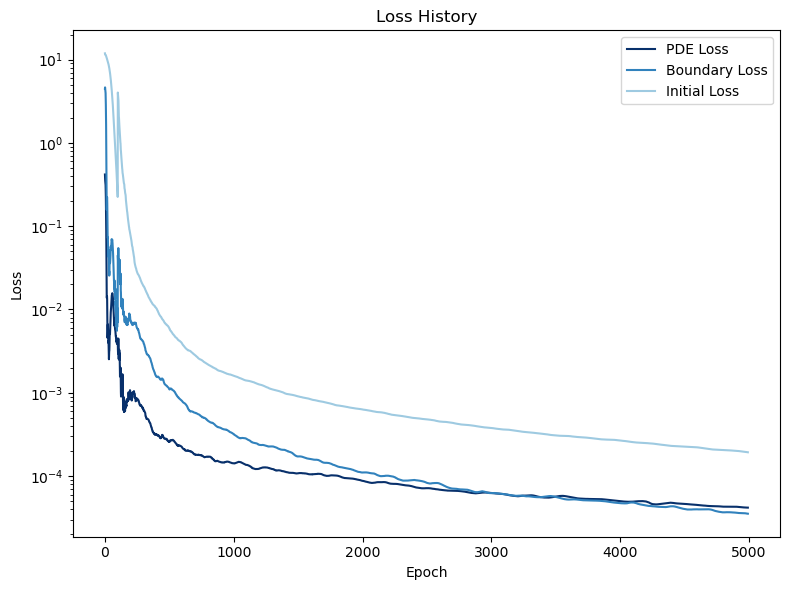

L2 Error:  0.7796873


In [8]:
with_fo = trainer.closure.get_state()
plot_loss(with_fo, backend='matplotlib', smooth=False)

fo_l2 = compare_with_mc(model, params, n_prices=200,
                          n_simulations=10_000, dtype=dtype, device=device, seed=42, split_output=True)
print("L2 Error: ", fo_l2['l2_rel_error']*100)

# save results in dict
with_fo['evaluation '] = fo_l2

import json
with open('long_training.json', 'w') as f:
    json.dump(with_fo, f, default=handle_serialization, indent=4)

In [2]:
# vpinn_bs1d_bc.py  – ASCII-only, PyTorch ≥1.13
# ------------------------------------------------------------------
#  1-D VPINN for   u_tau
#                –sigma^2/2 (u_xx – u_x)
#                –r u_x + r u = 0
#
# Weak integrand (after one IBP in x):
#     G = u_tau w
#       + 0.5*sigma^2 (u_x w_x + u_x w)
#       + r u_x w   – r u w
#
# Boundary residuals:
#   • bottom x = x_min :  R_bot = u_tau + r u    (Dirichlet in weak sense)
#   •   top  x = x_max :  R_top = u_x   – u
#
# Each boundary residual is integrated in τ with w = 1
# and added (squared) to the loss → still a variational statement.
# ------------------------------------------------------------------
import torch, time
from torch import nn, autograd

# ---------- parameters ----------
sigma, rate, T_fin = 0.2, 0.05, 1.0
x_min, x_max       = -6.0, 6.0
E, S               = 16, 10          # spatial elements, time slabs
p_deg, q_gl        = 1, 3            # Legendre {1,xi}, 3-point Gauss
epochs, lr         = 2500, 2e-3
device             = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(3)

# ---------- little Gauss table (q = 3) ----------
xi_1d = torch.tensor([-0.7745966692, 0.0, 0.7745966692], device=device)
wt_1d = torch.tensor([0.5555555556, 0.8888888889, 0.5555555556], device=device)

def map_interval(a, b, xi):
    mid, half = 0.5*(a+b), 0.5*(b-a)
    return mid + half*xi, half                 # x, |dx/dxi|

# ---------- Legendre basis p = 1 --------------
def phi_val(xi):
    return torch.stack((torch.ones_like(xi), xi), dim=-1)          # (q,2)

def phi_dx(xi, J):                                                 # (q,2)
    fac = 2.0 / J                         # d/dx = (2/J) d/dxi
    g0 = torch.zeros_like(xi)
    g1 = torch.ones_like(xi) * fac
    return torch.stack((g0, g1), dim=-1)

# ---------- payoff & trial net ----------------
def payoff(x):                    # European call (scaled)
    return torch.relu(torch.exp(x) - 1.0)

class Net(nn.Module):
    def __init__(self, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(2, width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.mlp = nn.Sequential(*layers)
    def forward(self, tau_x):
        return self.mlp(tau_x)

net = Net().to(device)

# ---------- uniform mesh ----------------------
x_edges = torch.linspace(x_min, x_max, E+1, device=device)
t_edges = torch.linspace(0.0 , T_fin, S+1, device=device)

# ---------- VPINN loss ------------------------
def loss_vpinn():
    loss = torch.zeros(1, device=device)

    # --- space-time slab loop
    for s in range(S):
        eta, Jt = xi_1d.view(-1,1), None
        tau_g1, Jt = map_interval(t_edges[s], t_edges[s+1], eta)           # (q,1)

        for e in range(E):
            xi, Jx = xi_1d.view(1,-1), None
            x_g1,  Jx = map_interval(x_edges[e], x_edges[e+1], xi)         # (1,q)

            # tensor-product grid (q*q,1)
            tau_g, x_g = torch.meshgrid(tau_g1.squeeze(),
                                         x_g1.squeeze(), indexing='ij')
            tau_g = tau_g.reshape(-1,1).requires_grad_(True)
            x_g   = x_g.reshape(-1,1).requires_grad_(True)

            u_hat = payoff(x_g) + tau_g * net(torch.cat((tau_g, x_g), dim=1))

            u_tau = autograd.grad(u_hat, tau_g, torch.ones_like(u_hat),
                                  retain_graph=True, create_graph=True)[0]
            u_x   = autograd.grad(u_hat, x_g, torch.ones_like(u_hat),
                                  retain_graph=True, create_graph=True)[0]

            # basis values on grid
            phi   = phi_val(xi_1d) .repeat_interleave(q_gl,0)              # (q*q,2)
            dphi  = phi_dx(xi_1d, Jx) .repeat_interleave(q_gl,0)           # (q*q,2)

            # quadrature weights
            W = (wt_1d * Jt).view(-1,1) @ (wt_1d * Jx).view(1,-1)
            W = W.reshape(-1,1)

            for m in range(p_deg+1):
                w   = phi[:,m:m+1]
                w_x = dphi[:,m:m+1]

                G = ( u_tau * w
                      + 0.5*sigma**2 * (u_x * w_x + u_x * w)
                      + rate * u_x * w
                      - rate * u_hat * w )

                moment = torch.sum(W * G)
                loss   = loss + moment*moment

    # ----- boundary weak residuals -----------------------------
    # bottom face  x = x_min  :  u_tau + r u = 0
    tau_b = torch.rand(400,1,device=device) * T_fin
    tau_b = tau_b.requires_grad_(True)
    x_bot = torch.full_like(tau_b, x_min).requires_grad_(True)
    u_bot = payoff(x_bot) + tau_b * net(torch.cat((tau_b, x_bot), dim=1))
    u_tau_bot = autograd.grad(u_bot, tau_b, torch.ones_like(u_bot),
                              retain_graph=True, create_graph=True)[0]
    R_bot = u_tau_bot + rate * u_bot
    loss += torch.mean(R_bot**2)

    # top face   x = x_max  :  u_x - u = 0
    x_top = torch.full_like(tau_b, x_max).requires_grad_(True)
    u_top = payoff(x_top) + tau_b * net(torch.cat((tau_b, x_top), dim=1))
    u_x_top = autograd.grad(u_top, x_top, torch.ones_like(u_top),
                            retain_graph=True, create_graph=True)[0]
    R_top = u_x_top - u_top
    loss += torch.mean(R_top**2)

    return loss
# ---------------------------------------------------------------
opt = torch.optim.Adam(net.parameters(), lr=lr)
t0  = time.perf_counter()
for ep in range(1, epochs+1):
    opt.zero_grad()
    L = loss_vpinn()
    L.backward()
    opt.step()
    if ep == 1 or ep % 250 == 0:
        print(f"epoch {ep:4d}   loss = {L.item():.4e}")
print(f"done in {time.perf_counter()-t0:.1f}s")

# quick sanity print
with torch.no_grad():
    tau_now = torch.tensor([[T_fin]], device=device)
    xs      = torch.linspace(-1.0, 1.0, 5, device=device).unsqueeze(1)
    u_pred  = payoff(xs) + tau_now * net(torch.cat((tau_now.repeat(xs.size(0),1), xs), dim=1))
    print("\nτ = T_fin  option price (scaled):")
    for xv, uv in zip(xs[:,0].cpu(), u_pred[:,0].cpu()):
        print(f"x={xv:+5.2f}   û={uv:.6f}")


epoch    1   loss = 6.9759e+01
epoch  250   loss = 6.8626e+01
epoch  500   loss = 6.9743e+01
epoch  750   loss = 7.0051e+01
epoch 1000   loss = 6.6668e+01
epoch 1250   loss = 6.8399e+01
epoch 1500   loss = 7.0729e+01
epoch 1750   loss = 6.6898e+01


KeyboardInterrupt: 